In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [3]:
# Smillie Human stromal
adata1 = sc.read_mtx('Human stromal(smillie., 2019)/gene_sorted-Fib.matrix.mtx').T
genes1 = pd.read_csv('Human stromal(smillie., 2019)/Fib.genes.tsv', header=None, sep='\t')
adata1.var.index = genes1[0].values
barcodes1 = pd.read_csv('Human stromal(smillie., 2019)/Fib.barcodes2.tsv', header=None, sep='\t')
adata1.obs.index = barcodes1[0].values

In [4]:
# Kinchen Human mesenchyme
adata2 = sc.read_csv('Human Colonic Mesenchyme(Kinchen., 2018)/GSE114374_Human_UC_expression_matrix.txt.gz', delimiter='\t').T

In [5]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" 
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [6]:
def preprocess_adata(adata, ribo_gene_list=None, enable_kcnq1ot1_filter=True):
    adata.var_names_make_unique()

    # 마이토콘드리아 유전자 마킹
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

    # 리보솜 유전자 마킹
    if ribo_gene_list is not None:
        ribo_gene_list = set([gene.upper() for gene in ribo_gene_list])
        adata.var_names = adata.var_names.str.upper()
        adata.var['ribo'] = adata.var_names.isin(ribo_gene_list)
    else:
        adata.var['ribo'] = False

    # QC 메트릭 계산
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], 
                               percent_top=None, log1p=False, inplace=True)

    # 필터링
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)
    adata = adata[adata.obs["pct_counts_mt"] < 5]

    # Normalize + log
    sc.pp.normalize_total(adata, target_sum=1e4)
    adata.raw = adata.copy()
    sc.pp.log1p(adata)

    return adata

In [7]:
# 개별 데이터 전처리
data1 = preprocess_adata(adata1, ribo_gene_list=ribo_genes[0].values)
data1.obs['batch'] = "smillie"

data2 = preprocess_adata(adata2, ribo_gene_list=ribo_genes[0].values)
data2.obs['batch'] = "kinchen"

C:\Anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
# 유전자 교집합으로 정렬
data1.var_names_make_unique()
data2.var_names_make_unique()
data1.raw = None
data2.raw = None

shared_genes = pd.Index(data1.var_names).intersection(data2.var_names).unique()

data1 = data1[:, shared_genes]
data2 = data2[:, shared_genes]

In [15]:
# 병합
adata_combined = sc.concat(
    [data1, data2],
    label='batch',
    keys=['kinchen', 'smillie'],
    index_unique=None
)

In [16]:
# HVG 선택 전 원본 저장
adata_combined.raw = adata_combined.copy()

In [17]:
# HVG 선택
sc.pp.highly_variable_genes(adata_combined, flavor="seurat", batch_key="batch", n_top_genes=2000)
adata_combined = adata_combined[:, adata_combined.var.highly_variable].copy()

C:\Anaconda3\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


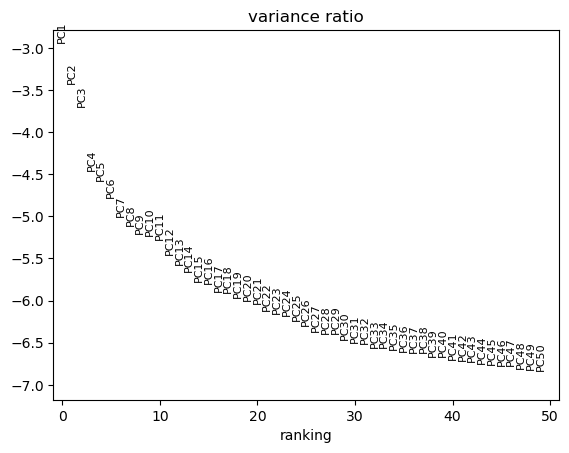

In [18]:
# 정규화 및 PCA
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_combined, log=True, n_pcs=50)

In [19]:
# Harmony 통합
sc.external.pp.harmony_integrate(adata_combined, key="batch")

2025-07-08 17:08:31,743 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~

In [20]:
# 최근접 이웃, UMAP, 클러스터링
sc.pp.neighbors(adata_combined, n_neighbors=30, n_pcs=50, use_rep="X_pca_harmony")
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined, resolution=1)

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_18892\2562598798.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=1)


In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

magma = plt.cm.get_cmap('magma', 256)
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])
new_colors = np.vstack((grey, magma_colors[20:])) 
custom_cmap1 = ListedColormap(new_colors)

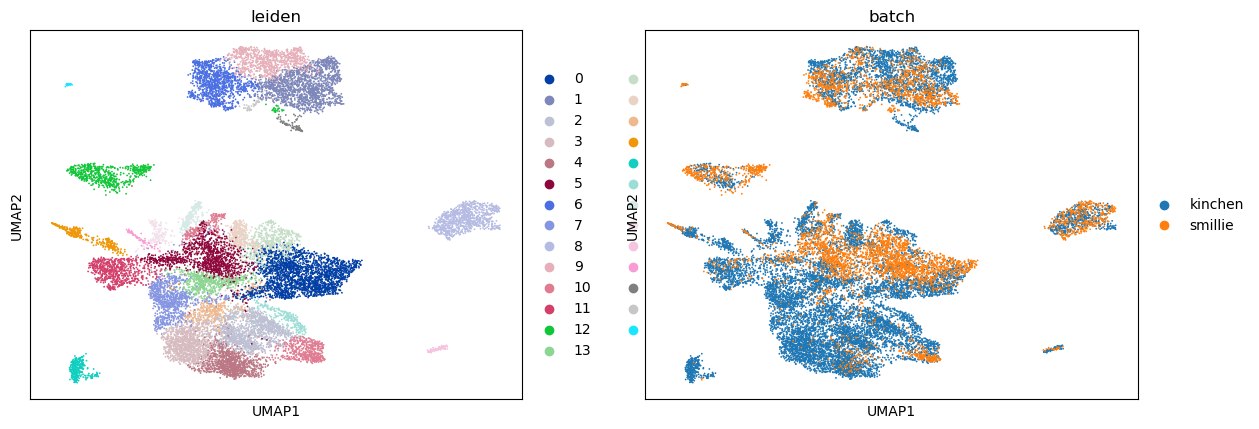

In [31]:
# 시각화
sc.pl.umap(adata_combined, color=["leiden", "batch"], use_raw=True)

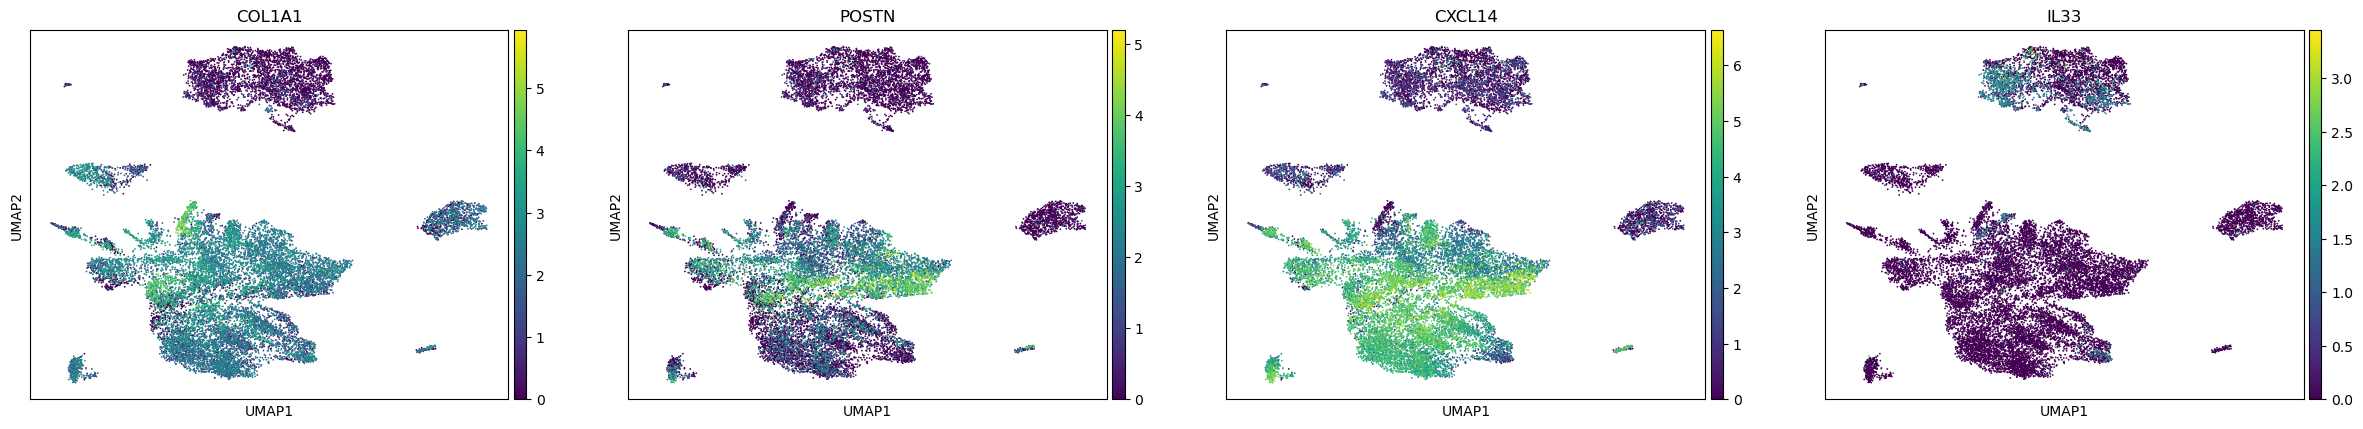

In [32]:
sc.pl.umap(adata_combined, color=["COL1A1", "POSTN", "CXCL14", "IL33"], use_raw=True)


In [23]:
pd.crosstab(adata_combined.obs['leiden'], adata_combined.obs['batch'], normalize='index')


batch    kinchen   smillie
leiden                    
0       0.545219  0.454781
1       0.643862  0.356138
2       0.959375  0.040625
3       0.989431  0.010569
4       0.914508  0.085492
5       0.389132  0.610868
6       0.600729  0.399271
7       0.977941  0.022059
8       0.582535  0.417465
9       0.822599  0.177401
10      0.635246  0.364754
11      0.913363  0.086637
12      0.383562  0.616438
13      0.865794  0.134206
14      0.347295  0.652705
15      0.884444  0.115556
16      0.963964  0.036036
17      0.890490  0.109510
18      0.990712  0.009288
19      0.987342  0.012658
20      0.859091  0.140909
21      0.994924  0.005076
22      0.793814  0.206186
23      0.730337  0.269663
24      1.000000  0.000000
25      0.465116  0.534884
26      0.235294  0.764706

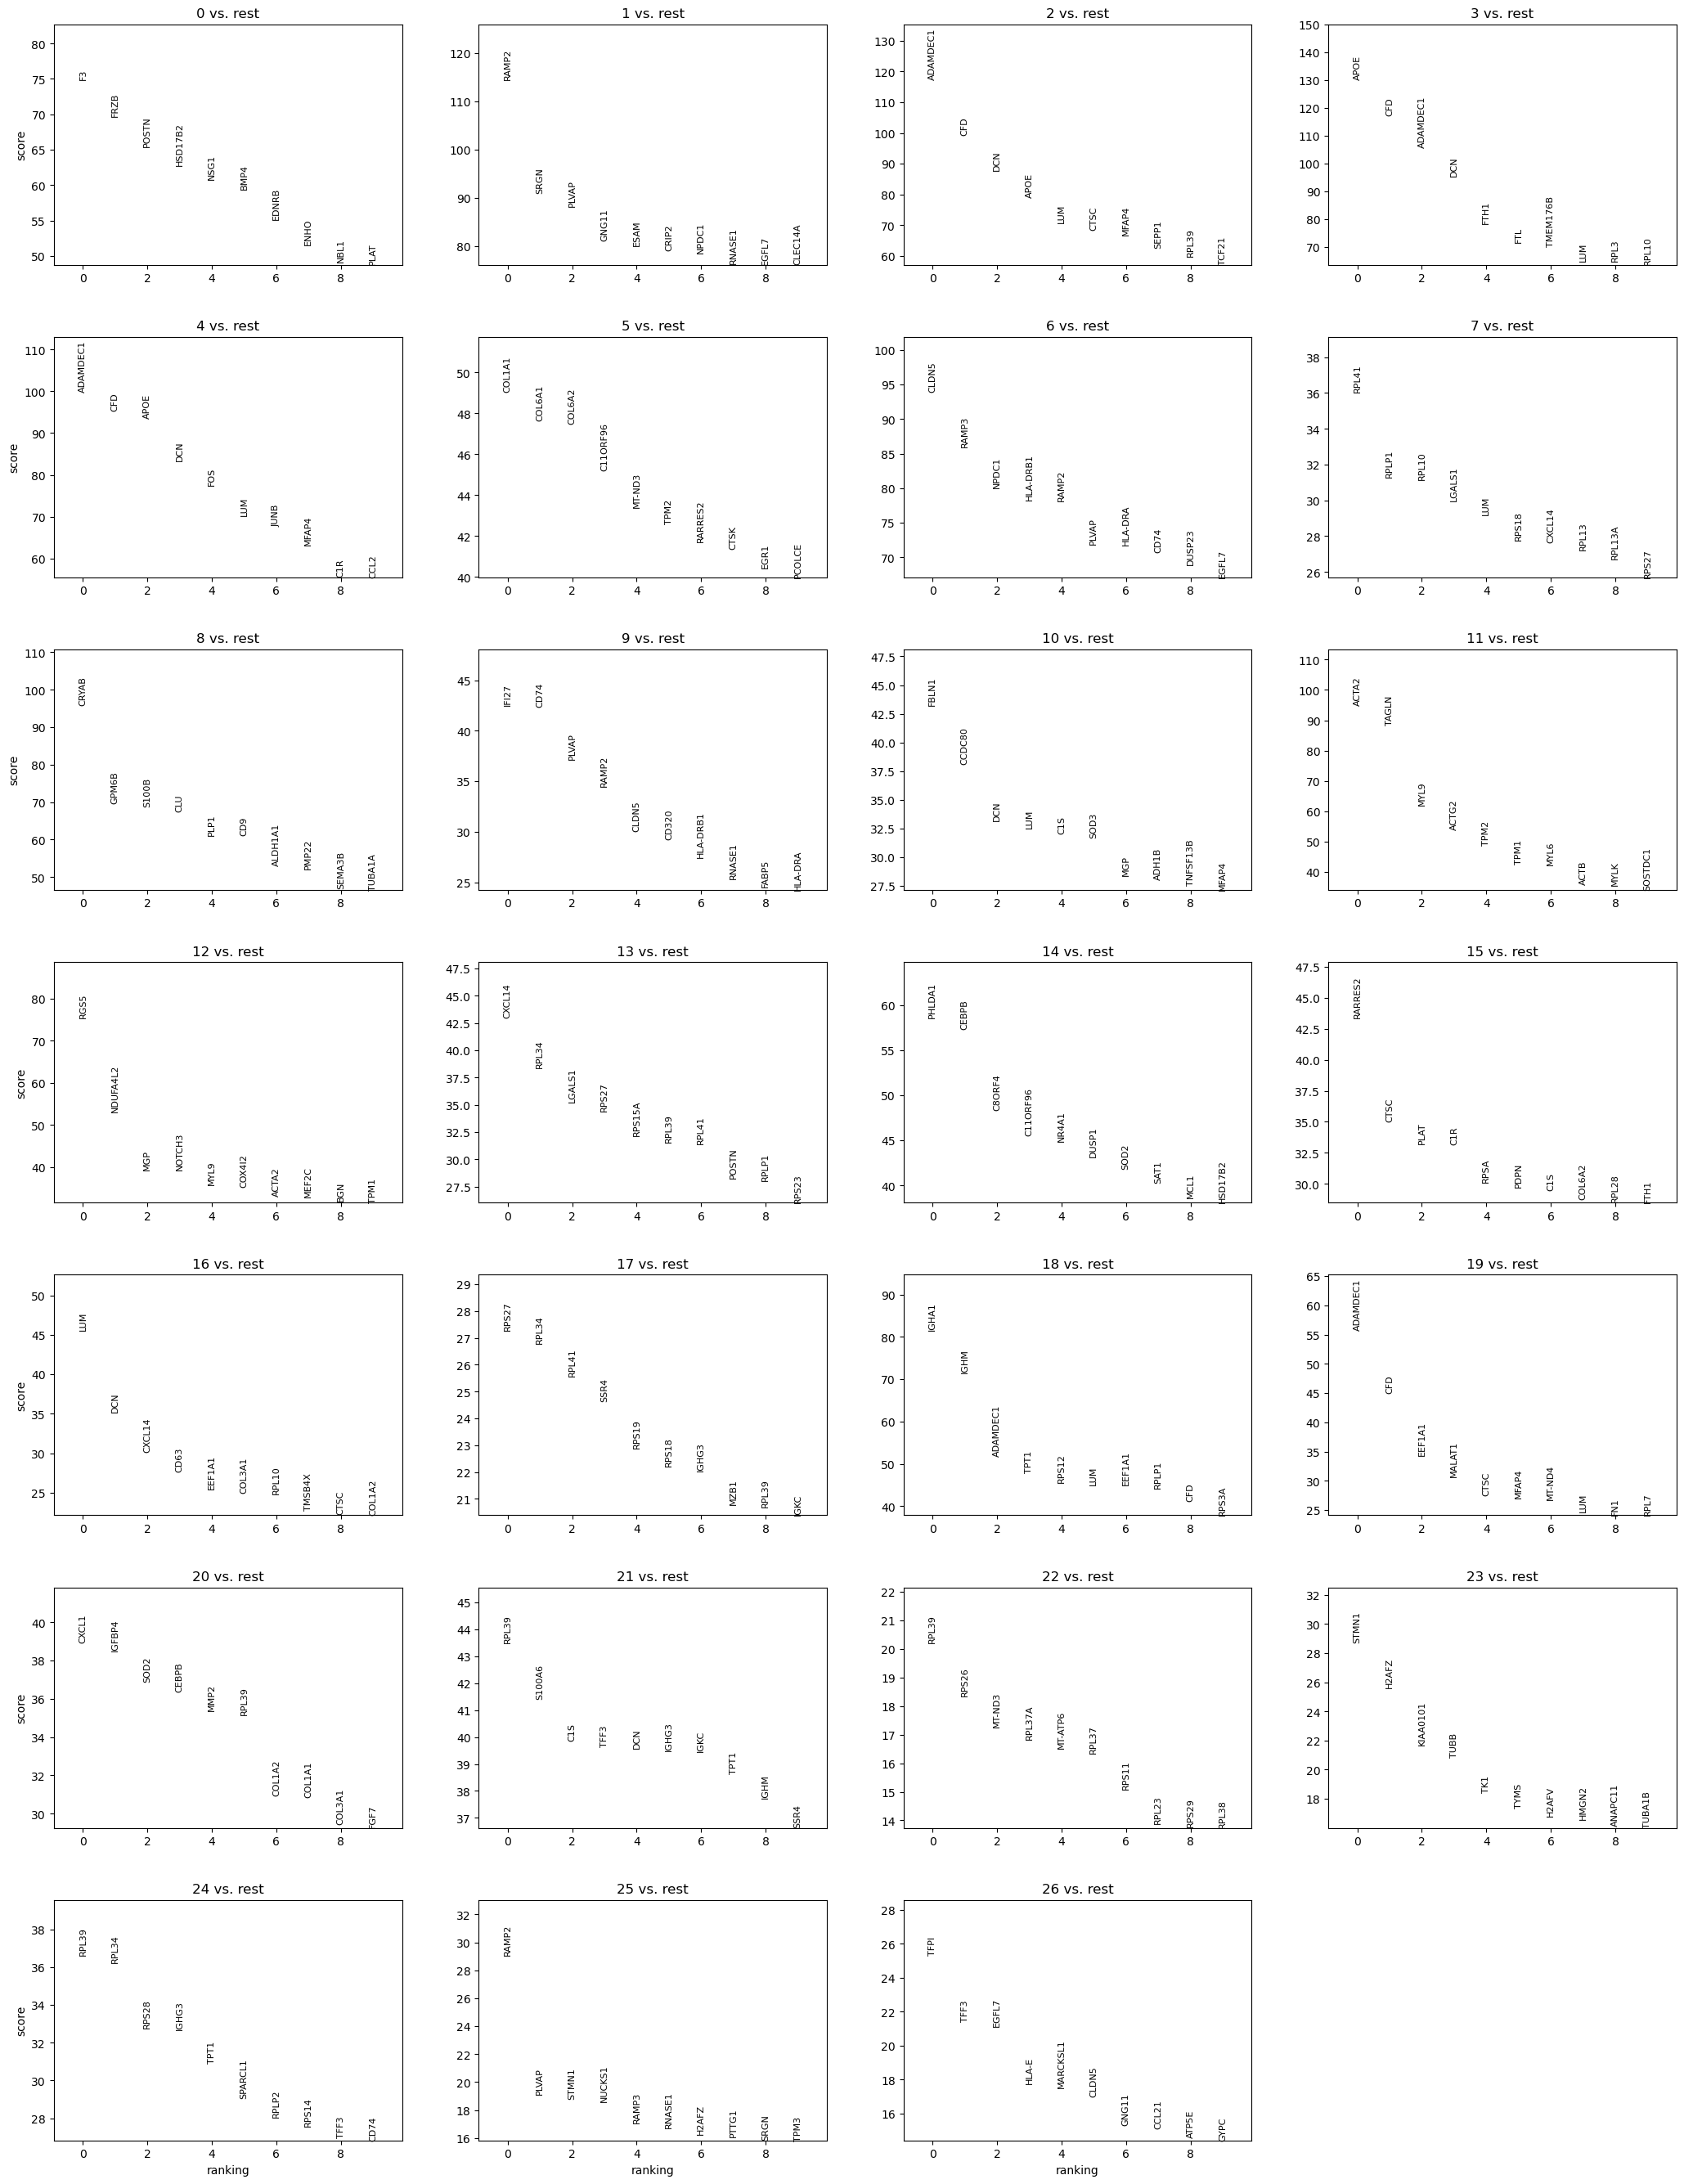

In [33]:
sc.tl.rank_genes_groups(adata_combined, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata_combined, n_genes=10, sharey=False)


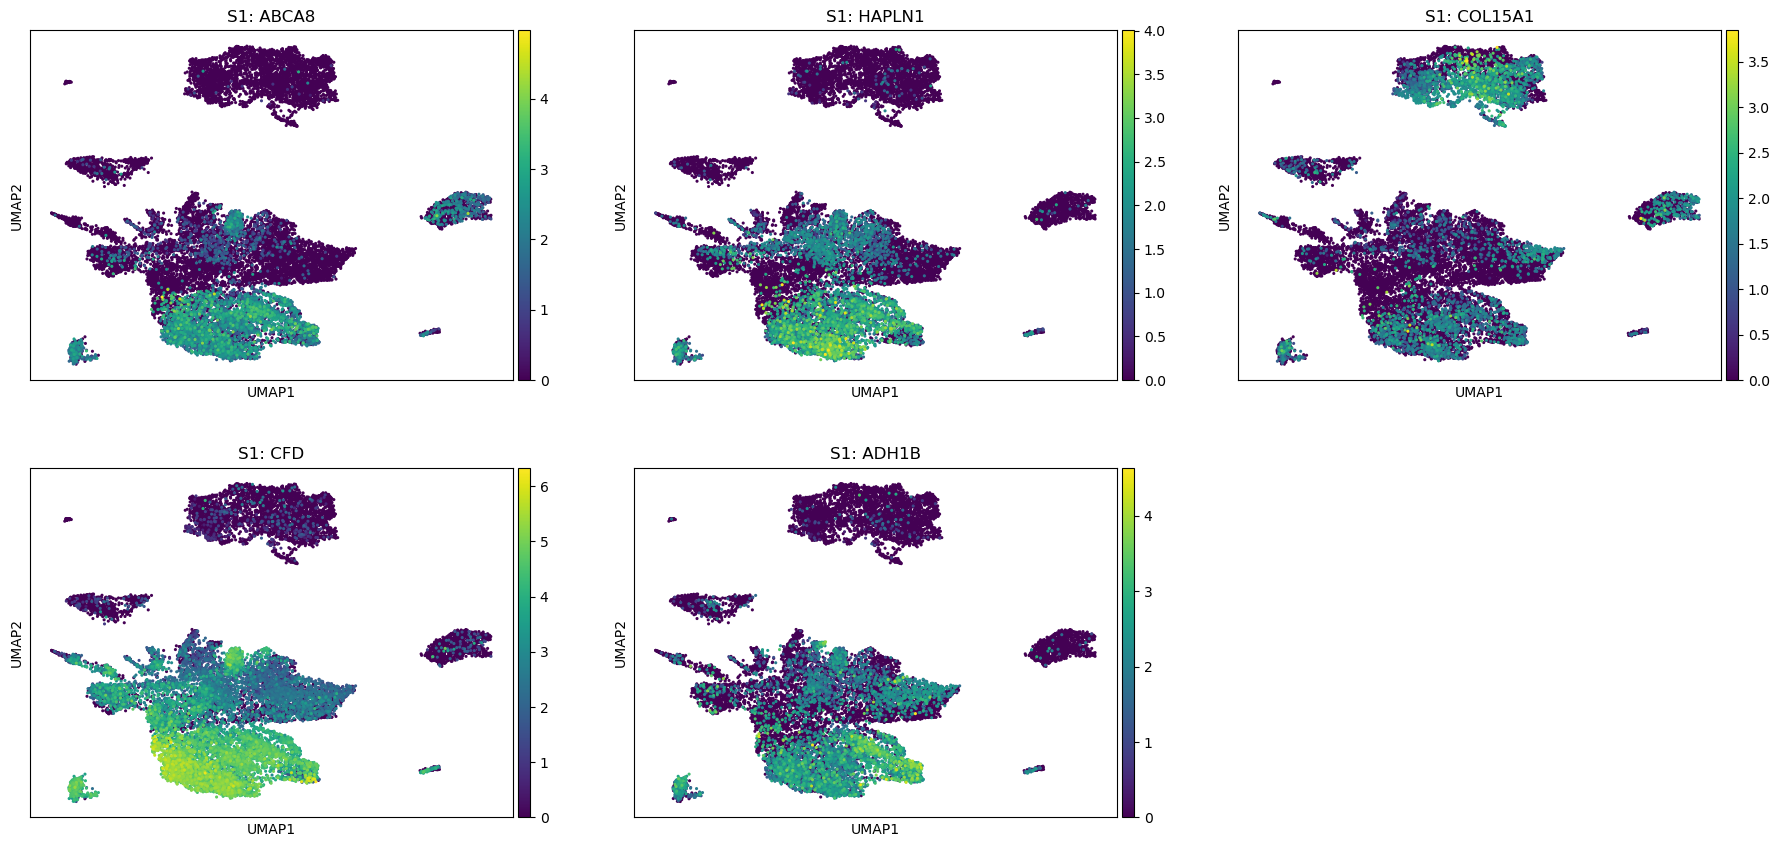

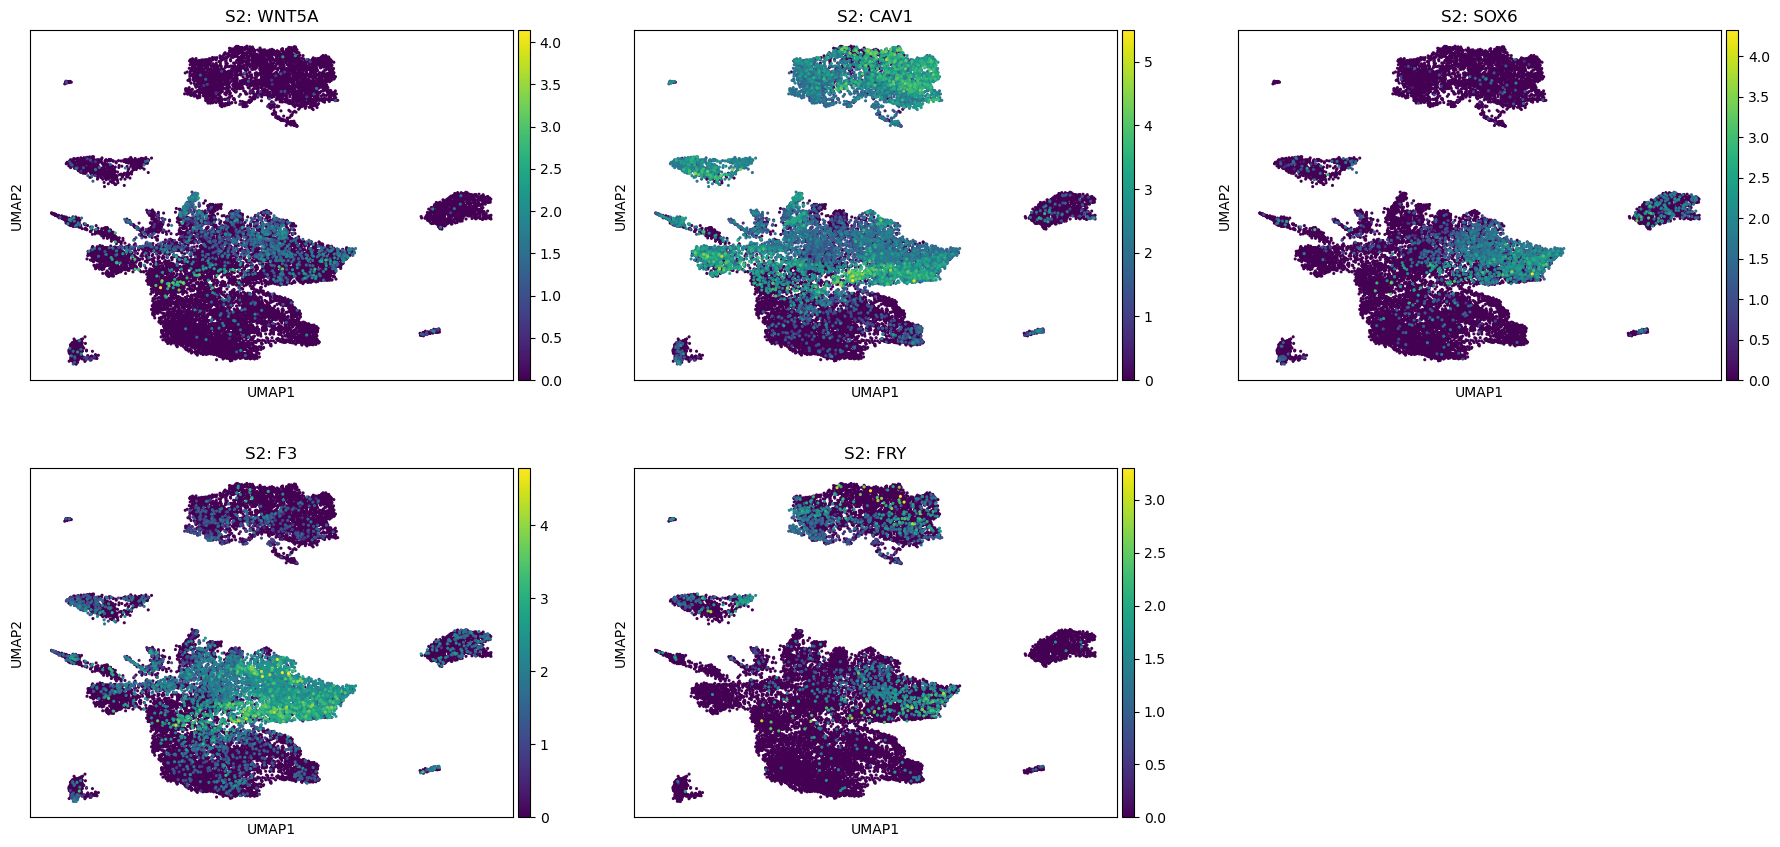

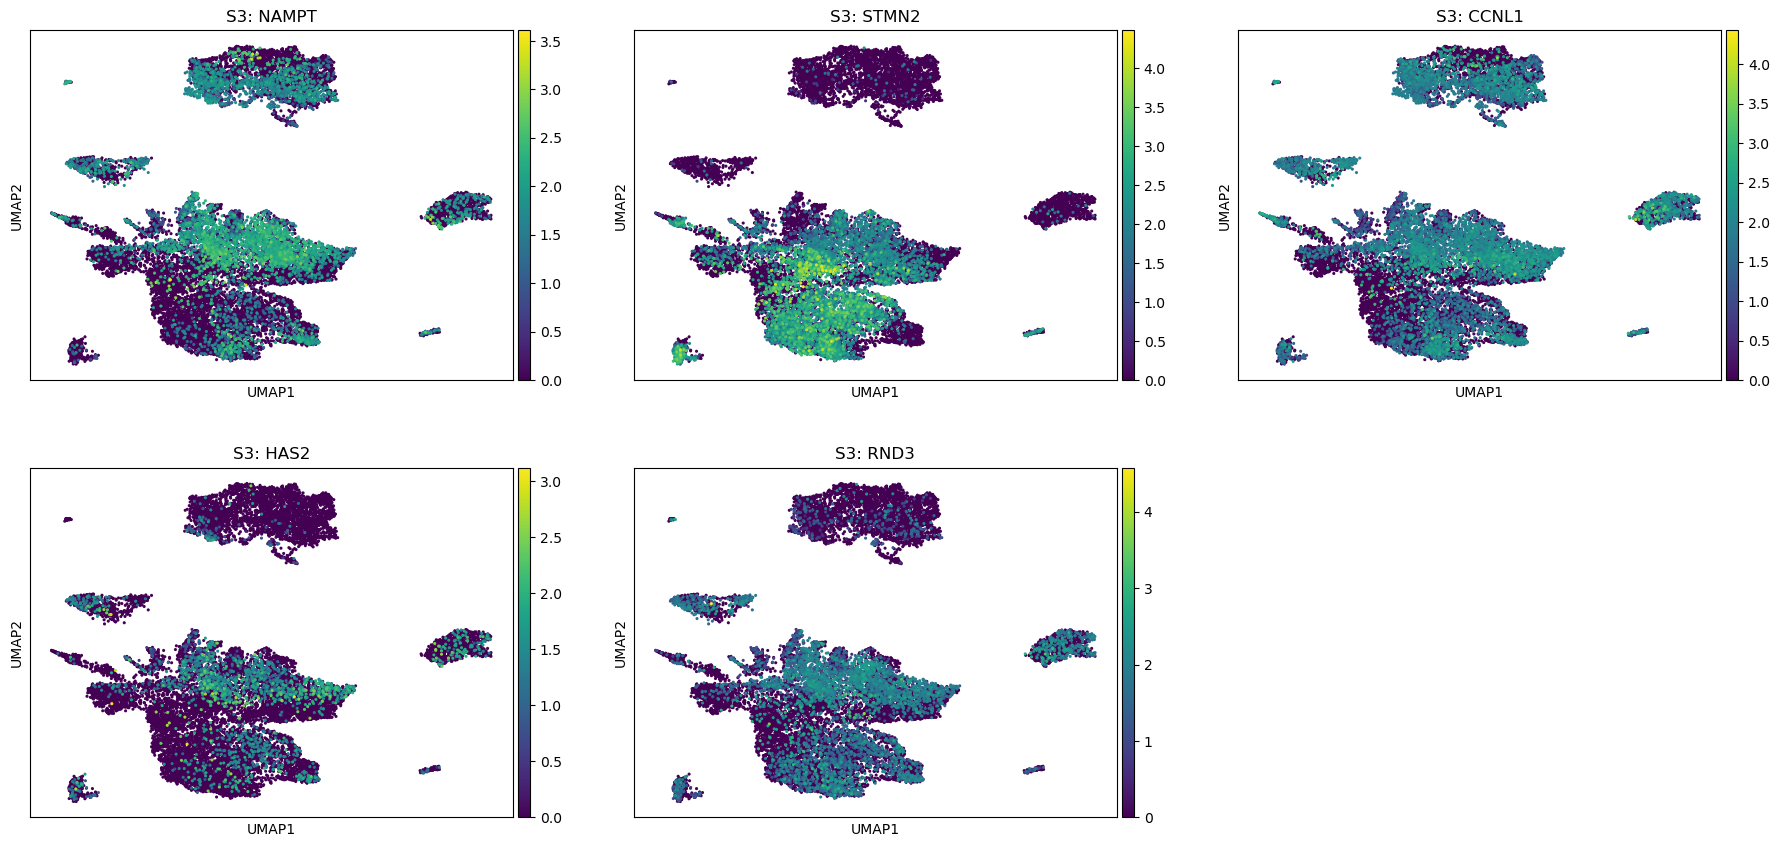

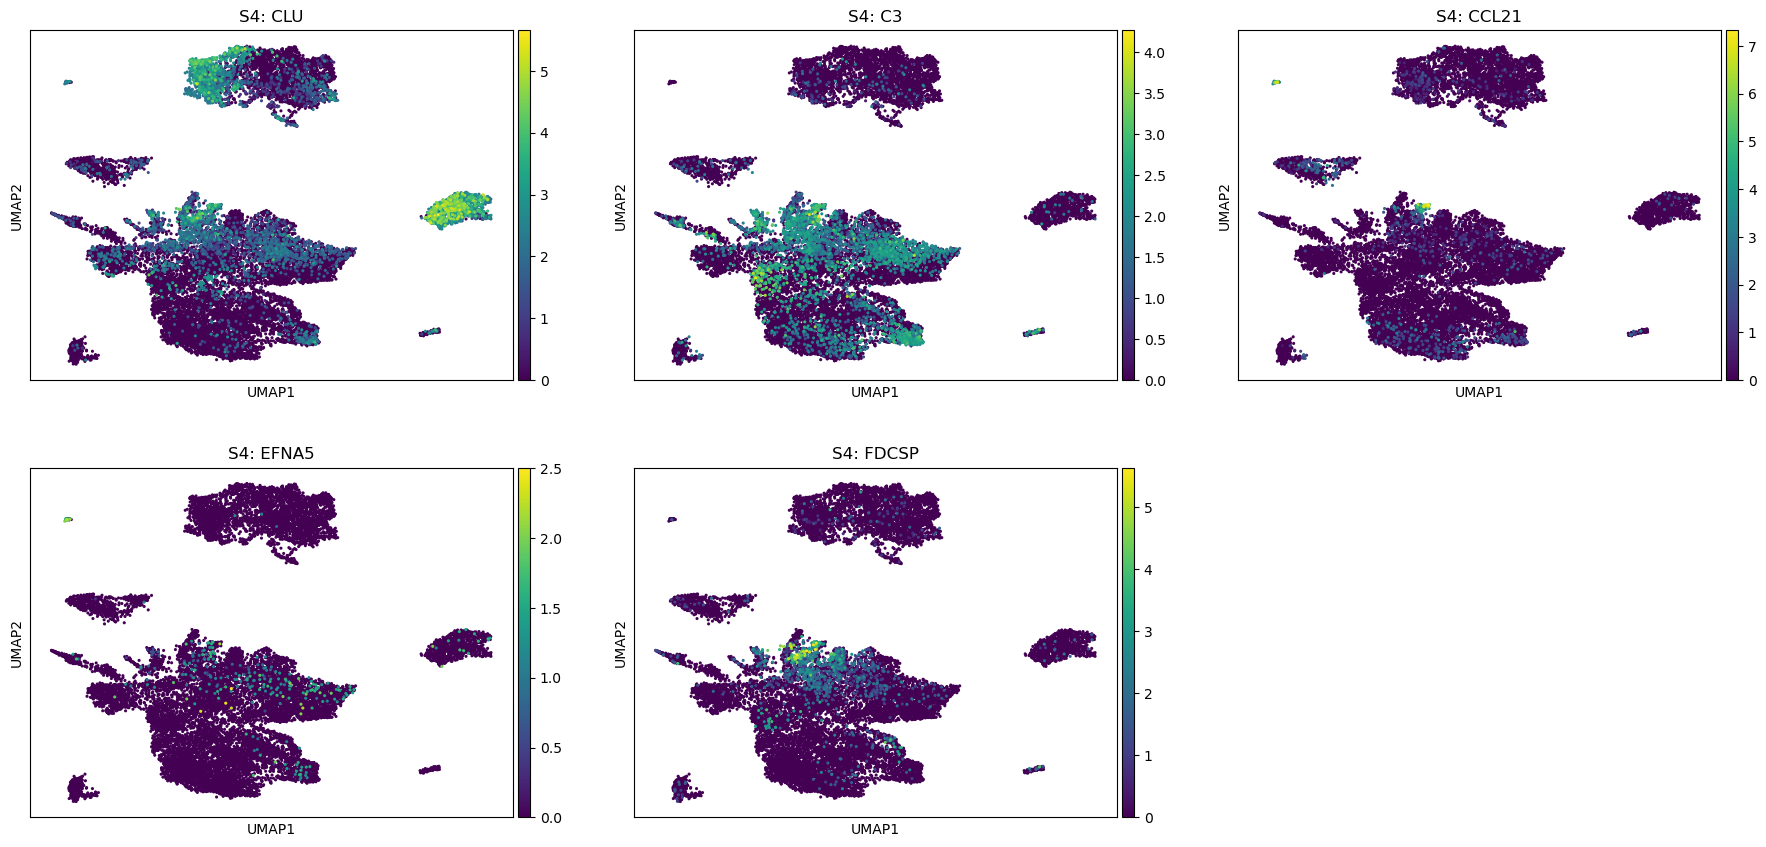

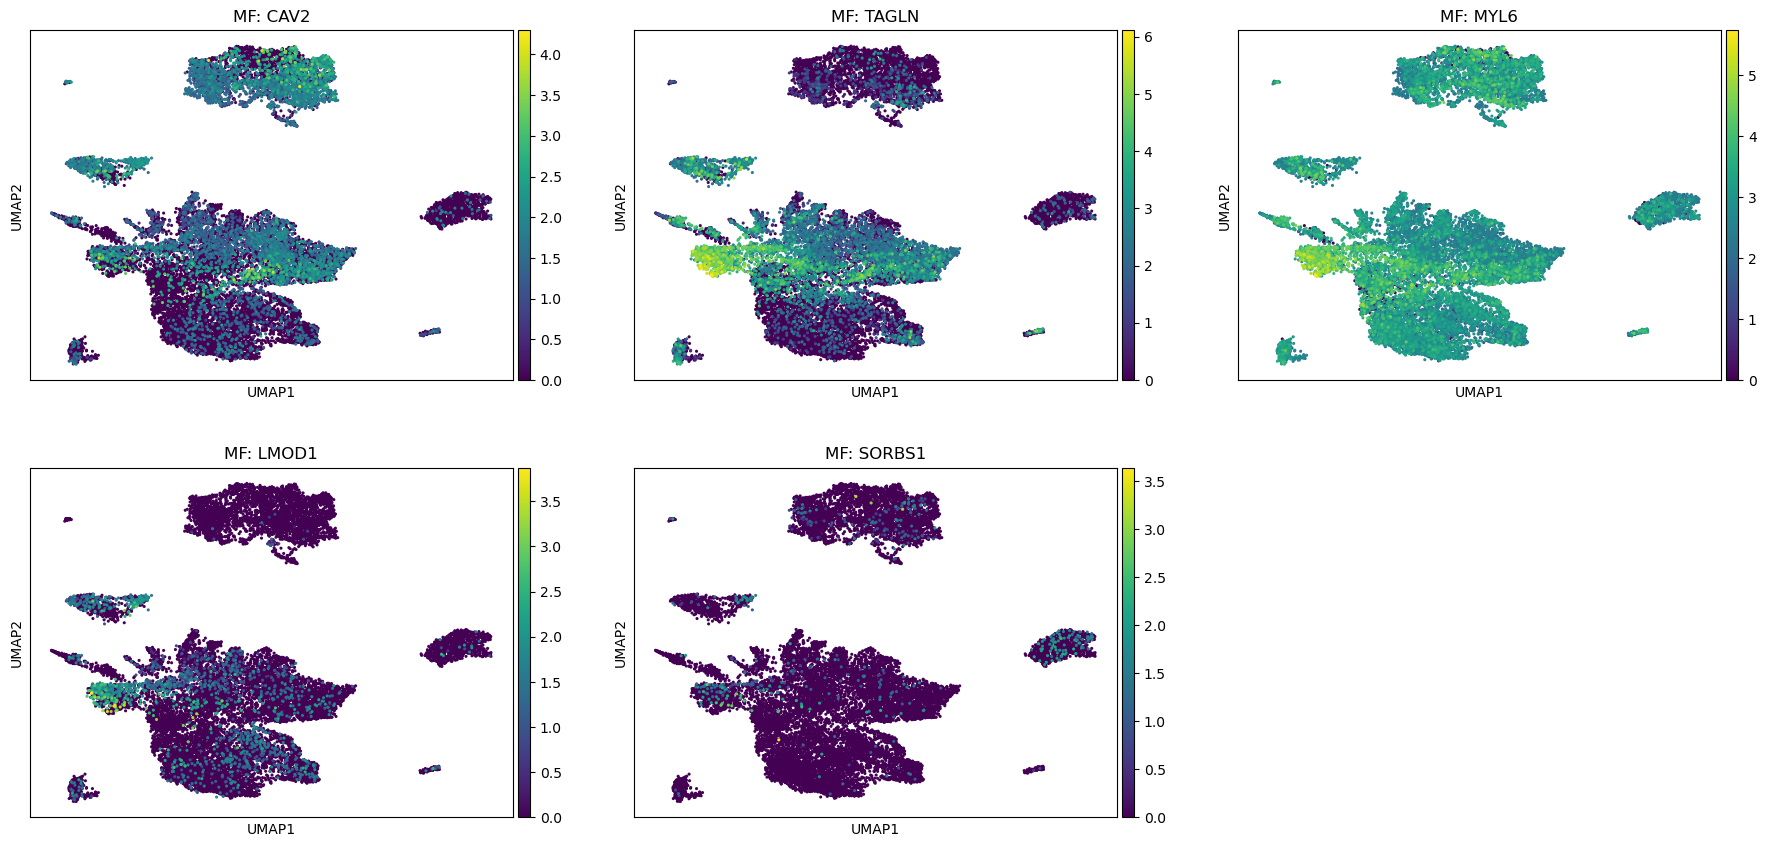

In [34]:
import matplotlib.pyplot as plt

# 클러스터별 마커 유전자 리스트 (상위 5개씩)
uc_cluster_markers = {
    "S1": ["ABCA8", "HAPLN1", "COL15A1", "CFD", "ADH1B"],
    "S2": ["WNT5A", "CAV1", "SOX6", "F3", "FRY"],
    "S3": ["NAMPT", "STMN2", "CCNL1", "HAS2", "RND3"],
    "S4": ["CLU", "C3", "CCL21", "EFNA5", "FDCSP"],
    "MF": ["CAV2", "TAGLN", "MYL6", "LMOD1", "SORBS1"]
}

# 시각화: 각 클러스터별 유전자 그룹 UMAP
for cluster, genes in uc_cluster_markers.items():
    # 실제 존재하는 유전자만 필터링
    valid_genes = [g for g in genes if g in adata_combined.raw.var_names]
    if valid_genes:
        sc.pl.umap(
            adata_combined,
            color=valid_genes,
            use_raw=True,
            cmap="viridis",
            title=[f"{cluster}: {gene}" for gene in valid_genes],
            ncols=3,
            size=20
        )


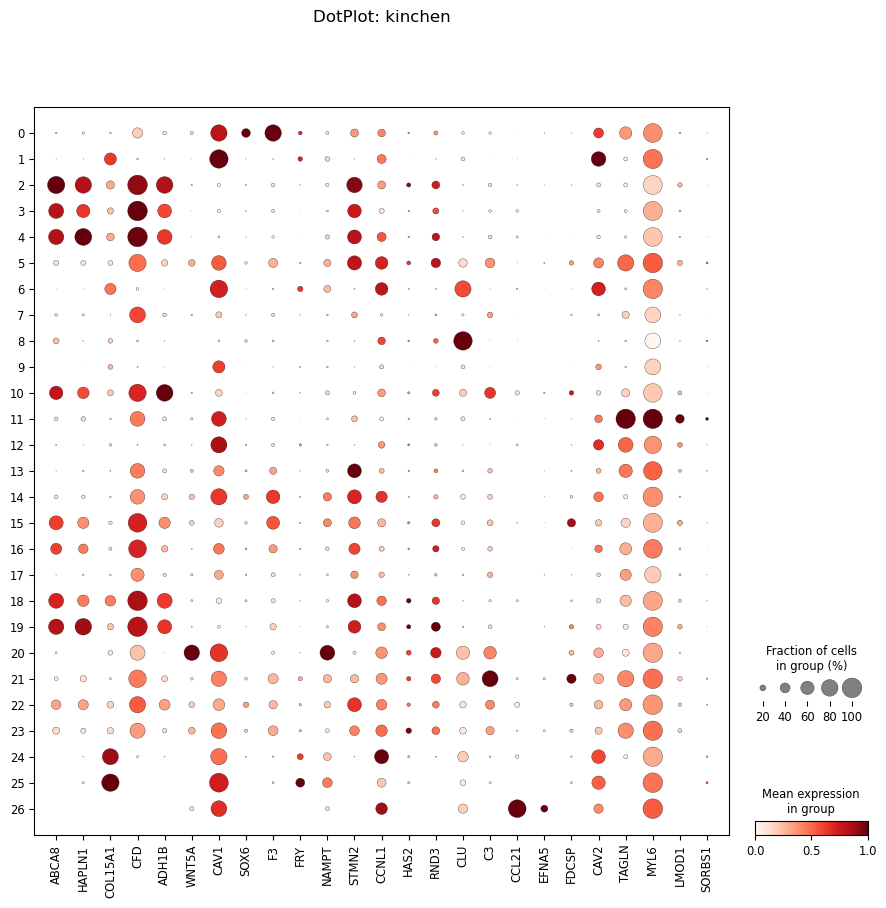

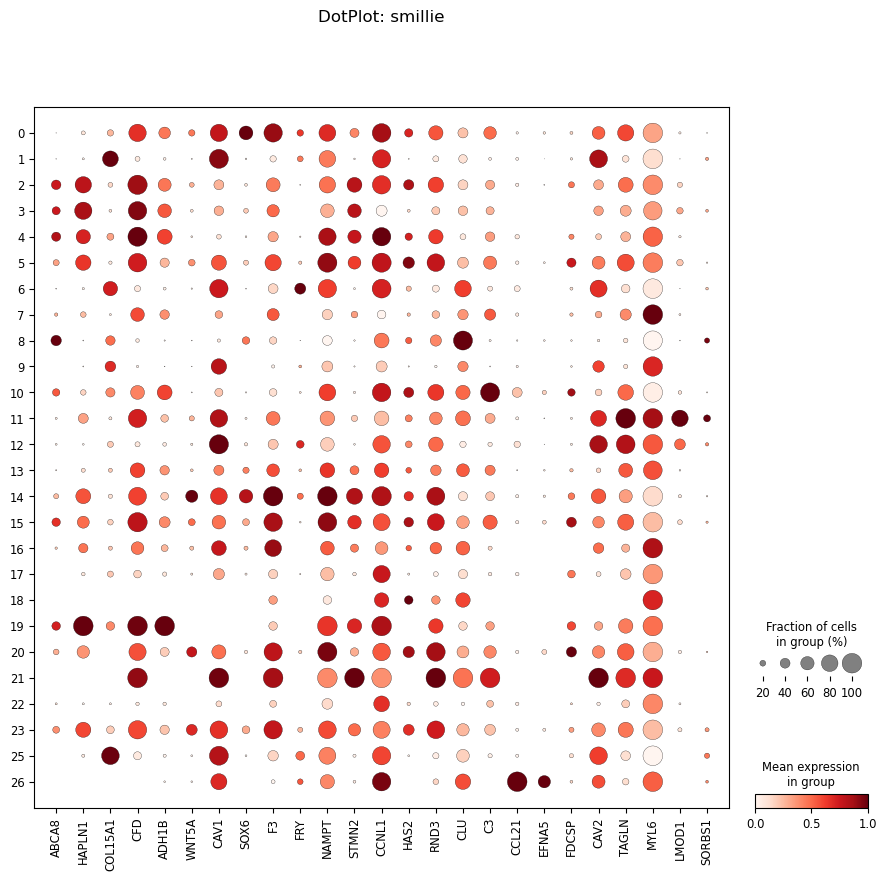

In [35]:

# 유전자 리스트 중 실제 데이터에 존재하는 유전자만 필터링
all_marker_genes = [gene for genes in uc_cluster_markers.values() for gene in genes]
valid_genes = [gene for gene in all_marker_genes if gene in adata_combined.raw.var_names]

# batch별 dotplot 시각화
for batch in adata_combined.obs['batch'].unique():
    sc.pl.dotplot(
        adata_combined[adata_combined.obs['batch'] == batch],
        var_names=valid_genes,
        groupby="leiden",
        use_raw=True,
        standard_scale="var",
        title=f"DotPlot: {batch}",
        show=True
    )